In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

import os
import pickle

from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid

Проверяем датасет (Всё нормализовано кроме столбцов с классами)

In [71]:
fraction = 0.05

In [72]:
# .sample(frac=0.1) - Для тестирования и быстроты работы возьмём только 10% от выборки
df = pd.read_csv('normalized_data.csv', encoding='ISO-8859-1').sample(frac=fraction, random_state=0)
df.head()

,year,price_in_euro,power_kw,power_ps,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,transmission_type,fuel_type
135641,0.642857,0.212011,0.164179,0.164634,0.007037,0.135135,0.039196,Automatic,Diesel
36995,0.214286,0.085066,0.227197,0.228049,0.013261,0.235235,0.071053,Automatic,Petrol
121769,0.821429,0.364362,0.175788,0.176829,0.008525,0.145145,0.011579,Manual,Petrol
70647,0.892857,0.874487,0.208955,0.209756,0.007307,0.143143,0.014605,Automatic,Diesel
9713,1.000000,0.770819,0.225539,0.225610,0.006360,0.138138,0.000276,Automatic,Diesel


Выводим данные для просмотра возможных кластеров (не используем столбцы с классами)

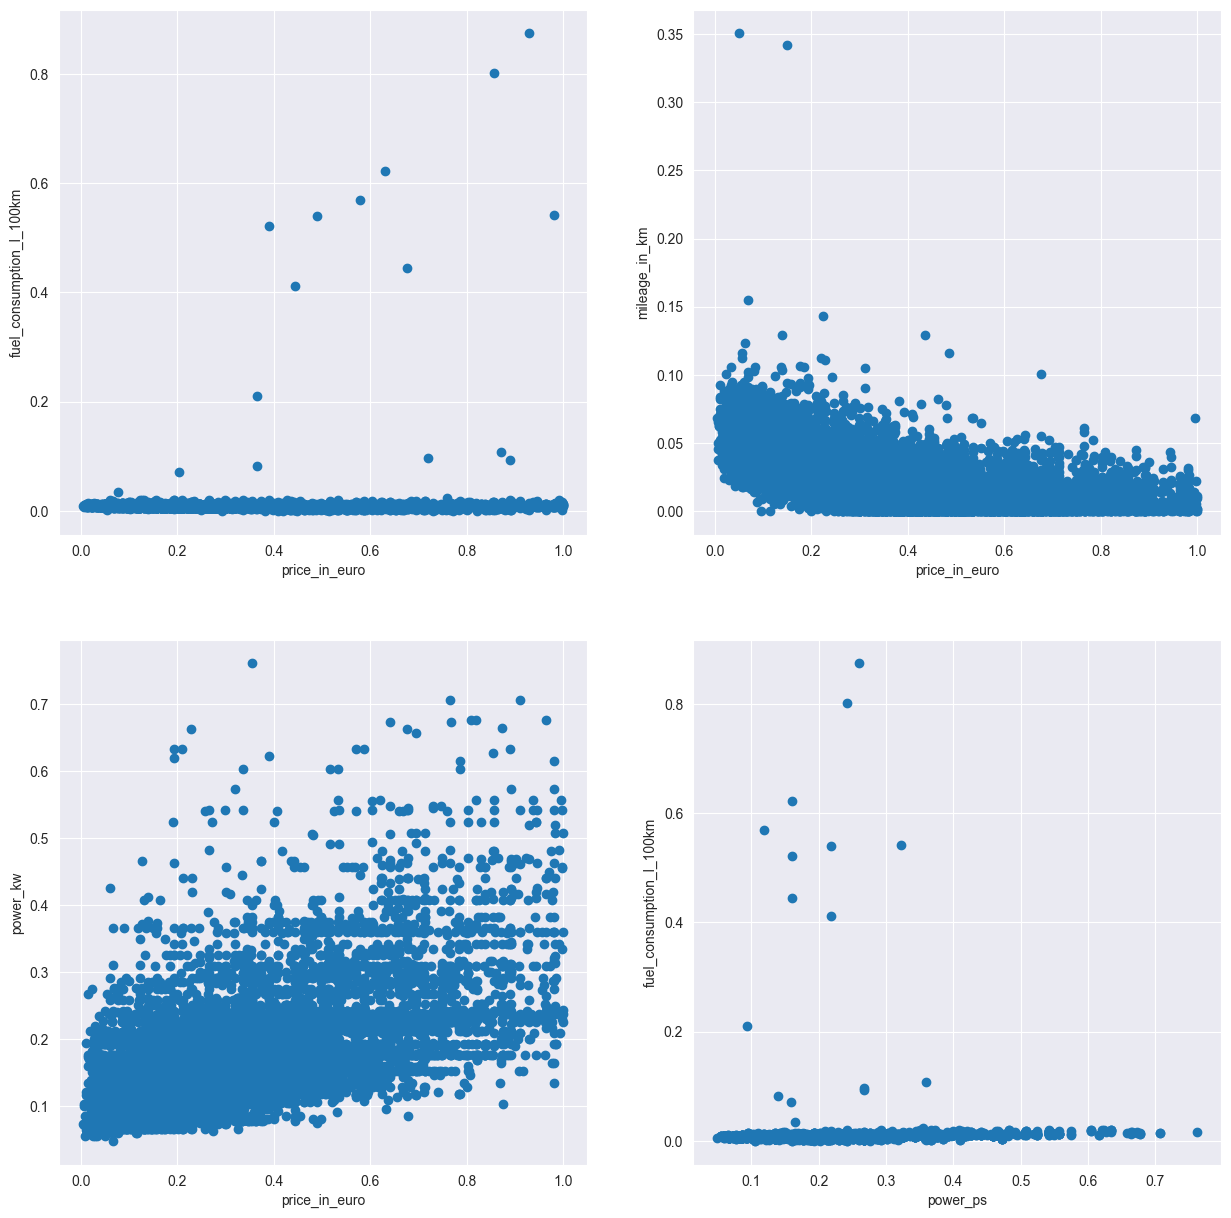

In [73]:
# Массив графиков 2 на 2, размер отображаемой картинки: 15 на 15
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
# Первый график рассеяния: стоимость и потребление топлива
ax[0][0].scatter(df["price_in_euro"], df["fuel_consumption_l_100km"])
ax[0][0].set_xlabel("price_in_euro")
ax[0][0].set_ylabel("fuel_consumption_l_100km")

# Второй график рассеяния: стоимость и пройденный километраж
ax[0][1].scatter(df["price_in_euro"], df["mileage_in_km"])
ax[0][1].set_xlabel("price_in_euro")
ax[0][1].set_ylabel("mileage_in_km")

# Второй график рассеяния: стоимость и мощность
ax[1][0].scatter(df["price_in_euro"], df["power_kw"])
ax[1][0].set_xlabel("price_in_euro")
ax[1][0].set_ylabel("power_kw")

# Второй график рассеяния: мощность и потребление топлива
ax[1][1].scatter(df["power_ps"], df["fuel_consumption_l_100km"], label="f")
ax[1][1].set_xlabel("power_ps")
ax[1][1].set_ylabel("fuel_consumption_l_100km")
plt.show()

Разбиваем на кластеры по самым подходящим параметрам (выбираем понравившийся график)

In [74]:
df_two = df[["price_in_euro", "fuel_consumption_l_100km"]]

Смотрим на результаты разбиения на кластеры

In [75]:
def prepare_and_plot(ax, model, title):
    labels = np.unique(model.labels_)  # получаем список уникальных меток
    colors = plt.cm.tab10(np.linspace(0, 1, len(labels)))    # создаем массив цветов
    ax.scatter(df["price_in_euro"], df["fuel_consumption_l_100km"], c=model.labels_, cmap='tab10')  # указываем нашу карту цветов
    # Создаем легенду в виде списка с данными о маркерах, цветах и метках
    handle_list = [plt.plot([], marker="o", ls="", color=color)[0] for color in colors]
    ax.legend(handle_list, labels, title='Classes')
    ax.set_xlabel("price_in_euro")
    ax.set_ylabel("fuel_consumption_l_100km")
    ax.set_title(title)

Используем GridSearch (подбор гиперпараметров для вышеперечисленных алгоритмов)

Выбираем гиперпараметры, которые будем перебирать

In [76]:
agglomerative_params = {
    "n_clusters": [2, 3, 4],
    "linkage": ["ward", "complete", "average"]
}

kmeans_params = {
    "n_clusters": [2, 3, 4],
    "n_init": [1]
}

dbscan_params = {
    "eps": [0.005, 0.05, 0.1],
    "min_samples": [2, 3, 6, 8]
}

In [77]:
# Создаем список из экземпляров алгоритмов и соответствующих гиперпараметров
algorithms = [
    (AgglomerativeClustering(), agglomerative_params),
    (KMeans(), kmeans_params),
    (DBSCAN(), dbscan_params)
]

best_models = {}  # Сохраняем лучшие модели

Обучаем модели

In [78]:

# Цикл по алгоритмам и их гиперпараметрам
for algorithm, params in algorithms:
    model_file = f'best_{algorithm.__class__.__name__}_model.pkl'
    
    if os.path.exists(model_file):
        # Если файл с моделью уже существует, загружаем модель из файла
        with open(model_file, 'rb') as f:
            best_model = pickle.load(f)
        print(f"Loaded model for {algorithm.__class__.__name__} from {model_file}")
    else:
        best_score = 0
        best_params = None
        best_model = None
    
        # Генерируем все комбинации гиперпараметров
        param_grid = list(ParameterGrid(params))
    
        # Цикл по комбинациям гиперпараметров
        for param in param_grid:
            # Устанавливаем гиперпараметры для текущей комбинации
            algorithm.set_params(**param)
    
            # Оцениваем модель
            # Используется метрика silhouette_score для оценки качества кластеризации
            algorithm.fit(df_two)
            labels = algorithm.labels_
            try:
                score = silhouette_score(df_two, labels)
            except ValueError:
                print(f"Error with scoring: {algorithm.__class__.__name__}. {param}")
                score = -1
            # Сохраняем лучшие гиперпараметры
           
            if score > best_score:
                best_score = score
                best_params = param
                best_model = algorithm
        # Выводим лучшие гиперпараметры для текущего алгоритма
        print(f"Best parameters for {algorithm.__class__.__name__}: {best_params}. Score: {best_score}")
    
        # Сохраняем лучшую модель
        with open(f'best_{algorithm.__class__.__name__}_model.pkl', 'wb') as f:
            pickle.dump(best_model, f)
        
    best_models[algorithm.__class__.__name__] = best_model  # Добавляем лучшую модель в список

Best parameters for AgglomerativeClustering: {'linkage': 'average', 'n_clusters': 2}. Score: 0.6611325599731973
Best parameters for KMeans: {'n_clusters': 2, 'n_init': 1}. Score: 0.5763120296703005
Best parameters for DBSCAN: {'eps': 0.1, 'min_samples': 6}. Score: 0.6412311542920411


In [79]:
h_clustering = best_models["AgglomerativeClustering"]
kmeans = best_models["KMeans"]
dbscan = best_models["DBSCAN"]

Визуализация полученных значений

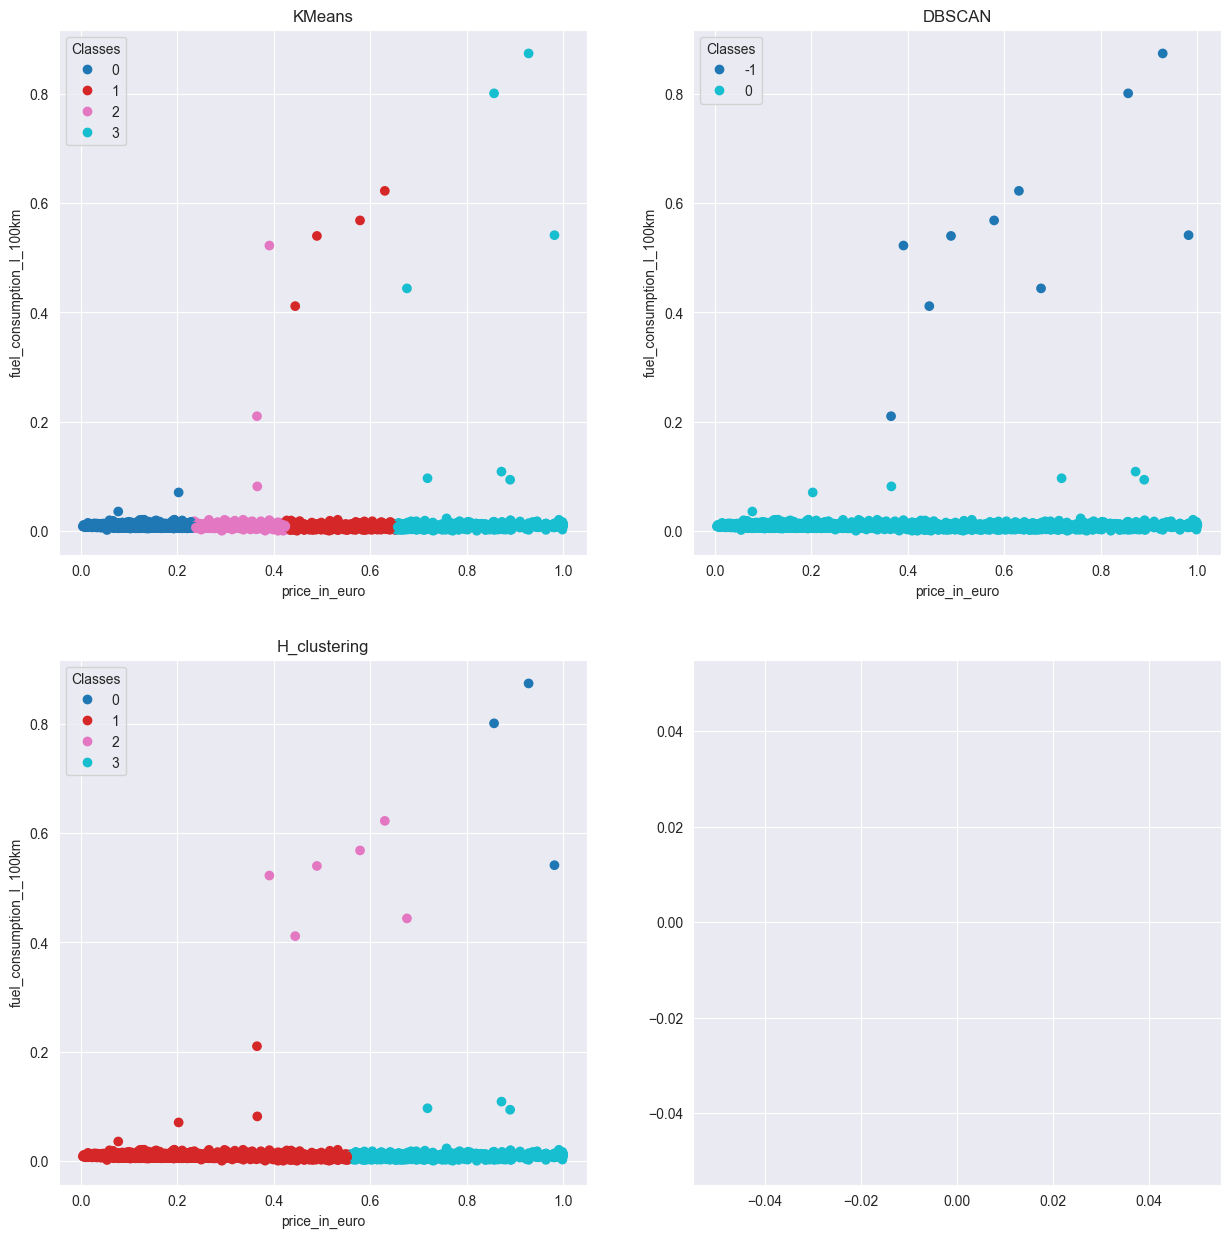

In [80]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

prepare_and_plot(ax[0][0], kmeans, "KMeans")
prepare_and_plot(ax[0][1], dbscan, "DBSCAN")
prepare_and_plot(ax[1][0], h_clustering, "H_clustering")
plt.show()

Сравнение разбиения на кластеры с помощью кластеризации с реальными

Получение всех данных без нормализации для проверки

In [81]:
df_global = pd.read_csv('not_normalized_data.csv', encoding='ISO-8859-1').sample(frac=fraction, random_state=0)

Выводим кластеры KMeans

In [82]:
df_KMeans = df_global.copy()[["price_in_euro", "fuel_consumption_l_100km"]]
df_KMeans["labels"] = kmeans.labels_
df_KMeans.groupby("labels").mean()

,price_in_euro,fuel_consumption_l_100km
labels,,
0,7912.511843,6.064878
1,29303.393953,6.442512
2,18544.603488,5.587965
3,43573.761583,8.510618


Выводим кластеры DBSCAN

In [83]:
df_DBSCAN = df_global.copy()[["price_in_euro", "fuel_consumption_l_100km"]]
df_DBSCAN["labels"] = dbscan.labels_
df_DBSCAN.groupby("labels").mean()

,price_in_euro,fuel_consumption_l_100km
labels,,
-1,35571.500000,409.000000
0,20708.525649,5.815443


Выводим кластеры AgglomerativeClustering

In [84]:
df_Agglomerative = df_global.copy()[["price_in_euro", "fuel_consumption_l_100km"]]
df_Agglomerative["labels"] = h_clustering.labels_
df_Agglomerative.groupby("labels").mean()

,price_in_euro,fuel_consumption_l_100km
labels,,
0,51653.333333,546.000000
1,16464.591130,5.706994
2,30033.333333,382.833333
3,39756.153121,6.390047


Выводим классы по типам атаки

In [85]:
df_global.groupby("fuel_type")[["price_in_euro", "fuel_consumption_l_100km"]].mean()

,price_in_euro,fuel_consumption_l_100km
fuel_type,,
CNG,16239.200000,4.740000
Diesel,22216.447124,5.513760
Diesel Hybrid,40147.100000,3.645000
Electric,33955.937500,255.625000
Hybrid,29876.160920,4.079540
LPG,16462.812500,6.728125
Other,37595.000000,3.700000
Petrol,19067.422318,6.138410


Выводим классы типов атаки в виде диаграммы рассеивания для наглядности (необязательный пункт, на этом этапе можно использовать совершенно разные инструменты)

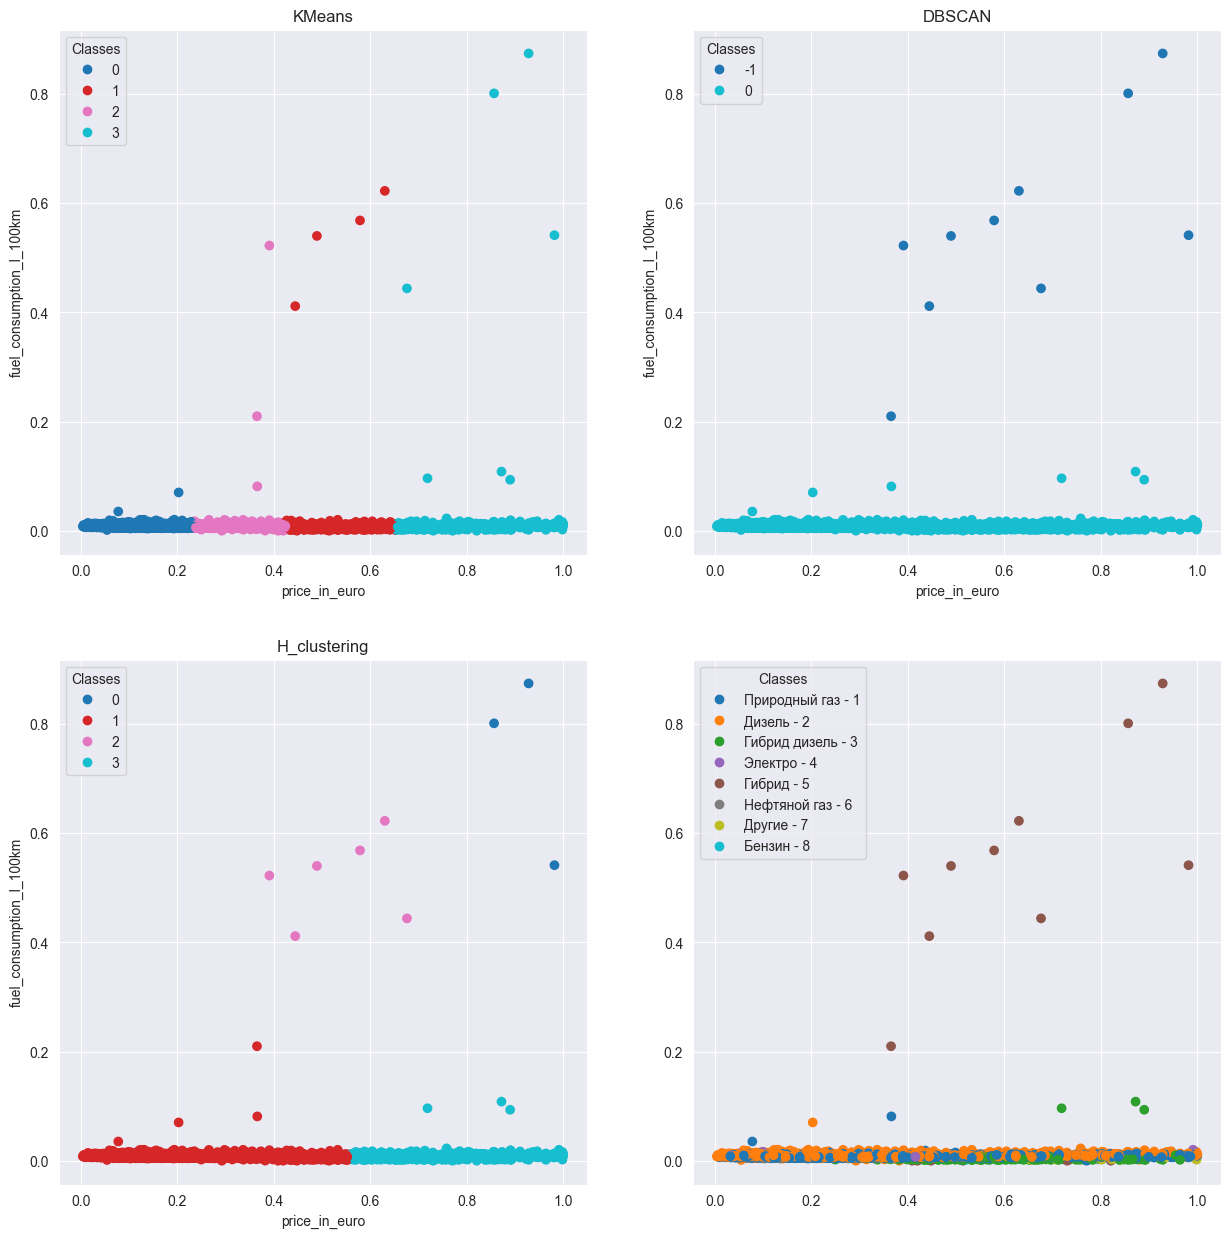

In [96]:
# Стандартные результаты кластеризации
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

prepare_and_plot(ax[0][0], kmeans, "KMeans")
prepare_and_plot(ax[0][1], dbscan, "DBSCAN")
prepare_and_plot(ax[1][0], h_clustering, "H_clustering")

df_global['fuel_type_num'] = pd.factorize(df['fuel_type'])[0]

# Добавление диаграммы с известными классами 
labels = ["Природный газ - 1", "Дизель - 2", "Гибрид дизель - 3", "Электро - 4", "Этанол - 5", "Гибрид - 6", "Водород - 7", "Нефтяной газ - 8", "Другие - 9", "Бензин - 10", "Неизвестное - 11"]  # получаем список уникальных меток
colors = plt.cm.tab10(np.linspace(0, 1, len(labels)))    # создаем массив цветов
ax[1][1].scatter(df["price_in_euro"], df["fuel_consumption_l_100km"], c=df_global['fuel_type_num'], cmap='tab10')  # указываем нашу карту цветов
# Создаем легенду в виде списка с данными о маркерах, цветах и метках
handle_list = [ax[1][1].plot([], marker="o", ls="", color=color)[0] for color in colors]
ax[1][1].legend(handle_list, labels, title='Classes')
plt.show()

In [101]:
df_global.groupby('fuel_type').first().reset_index()

,fuel_type,year,price_in_euro,power_kw,power_ps,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,transmission_type,fuel_type_num
0,CNG,2020,36860,96,131,3.5,96.0,99000,Automatic,5
1,Diesel,2013,11990,103,140,5.2,135.0,148946,Automatic,0
2,Diesel Hybrid,2021,31900,110,150,5.0,131.0,7152,Manual,6
3,Electric,2021,22990,100,136,0.0,0.0,23300,Automatic,4
4,Hybrid,2023,28980,85,116,5.0,113.0,15,Automatic,2
5,LPG,2022,19450,67,91,6.0,135.0,10,Manual,3
6,Other,2023,45990,131,178,6.2,142.0,3000,Automatic,7
7,Petrol,2001,4900,141,192,9.8,235.0,270000,Automatic,1
